# Sampling from a distribution over graphs

We will define a distribution over directed graphs, under the assumption that the vertices are known a-priori.

We'll focus on a class of distributions proposed by Mukherjee et al:

$$ P(G) \propto \exp \left( - \beta \cdot D(G, G^\prime) \right) $$

i.e., probability decreases exponentially with distance from some reference graph, $G^\prime$. 

The distance, $D$, could be any nonnegative notion of difference; but a useful default is Hamming distance between the graphs' edge sets.

In [1]:
include("DiGraph.jl")
using Gen
using .DiGraphs
using PyPlot

## Define a density over graphs

In [2]:
# in Gen, distributions are defined as singleton types:
struct GraphPriorDist <: Distribution{DiGraph} end
const graphpriordist = GraphPriorDist()

GraphPriorDist()

In [3]:
# define a hamming distance between graphs
function edge_hamming(g1::DiGraph{T}, g2::DiGraph{T}) where T
    return length(symdiff([g1.edges[i,:] for i=1:size(g1.edges)[1]],
                          [g2.edges[i,:] for i=1:size(g2.edges)[1]]))
end

# Define sampling methods for the graph distribution.
function Gen.random(gpd::GraphPriorDist, reference_graph::DiGraph{T}, beta::Number, distance_func::Function) where T
    return reference_graph
end

# if distance isn't specified, use hamming distance
function Gen.random(gpd::GraphPriorDist, reference_graph::DiGraph{T}, beta::Number) where T
    return Gen.random(gpd, reference_graph, beta, edge_hamming)
end

graphpriordist(reference_graph::DiGraph{T}, beta::Number) where T = Gen.random(graphpriordist, reference_graph, beta)

# Define a log-probability for this distribution.
function Gen.logpdf(gpd::GraphPriorDist, dg::DiGraph{T}, reference_graph::DiGraph{T}, beta::Number, distance_func::Function) where T
    return exp( -beta * distance_func(dg, reference_graph) )
end

# Again: use hamming distance by default
function Gen.logpdf(gpd::GraphPriorDist, dg::DiGraph{T}, reference_graph::DiGraph{T}, beta::Number) where T
    return Gen.logpdf(gpd, dg, reference_graph, beta, edge_hamming)
end


There are some issues with our construction:
1. This distribution is _unnormalized_. 
2. This distribution is _not generative_. It doesn't prescribe a sampling method.


However, our implementation should allow Gen's Metropolis-Hastings sampler to 'play nicely' with this distribution.
1. The distribution is unnormalized -- this means that the `logpdf` will not return correct values. However, the thing that _really_ matters in MH sampling is **change** in log-probability. And our logpdf implementation will correctly compute those.
2. The distribution isn't generative, but MH won't require us to explicitly sample from the distribution -- the whole point of MH is that it will allow us to sample from (unnormalized) log densities that have no generative description. As long as we provide a proposal distribution, we'll be fine.

### Example reference graph

We'll build an actual reference graph here, for illustrative purposes.

In [4]:
# Define a simple node type
struct Node
    name::String
    x::Float64
    y::Float64
end

In [6]:
# Define a mapping between string labels and nodes
vertex_dict = Dict("animal" => Node("animal", 0., 0.),
"mammal" => Node("mammal", -4., -1.),
"dog" => Node("dog", -5., -2.),
"cat" => Node("cat", -4., -2.),
"calico" => Node("calico", -4., -3.), 
"fish" => Node("fish", -1., -1.),
"bird" => Node("bird", 1., -1.),
"reptile" => Node("reptile", 3.0, -1.0),
"crocodile" => Node("crocodile", 4.0, -2.0),
"snake" => Node("snake", 2.0, -2.0),
"shark" => Node("shark", -2.0, -2.0),
"piranha" => Node("piranha", -0.0, -2.0)
);

In [7]:
example_tree = DiGraph(["mammal" "animal";
        "cat" "mammal";
        "calico" "cat";
        "dog" "mammal";
        "fish" "animal";
        "shark" "fish";
        "piranha" "fish";
        "bird" "animal";
        "reptile" "animal";
        "crocodile" "reptile";
        "snake" "reptile"])

DiGraph{String}(Set(["calico", "fish", "snake", "mammal", "dog", "reptile", "shark", "animal", "cat", "crocodile", "bird", "piranha"]), ["mammal" "animal"; "cat" "mammal"; … ; "crocodile" "reptile"; "snake" "reptile"])

### Some visualization machinery

We'll write some functions for visualizing graphs.

In [37]:
function visualize_vertices(digraph::DiGraph{T}, vertex_dict::Dict{T,Node}) where T
    xyn = [[vertex_dict[v].x vertex_dict[v].y vertex_dict[v].name] for v in digraph.vertices]
    xyn = vcat(xyn...)
    scatter(xyn[:,1], xyn[:,2], s=120)
    for i=1:size(xyn)[1]
        annotate(xyn[i,3], (xyn[i,1], xyn[i,2]))
    end
end


function visualize_edges(digraph::DiGraph{T}, vertex_dict::Dict{T,Node}) where T
    for i=1:size(digraph.edges)[1]
        xs = [vertex_dict[digraph.edges[i,1]].x; vertex_dict[digraph.edges[i,2]].x]
        ys = [vertex_dict[digraph.edges[i,1]].y; vertex_dict[digraph.edges[i,2]].y]
        dx = xs[2] - xs[1]
        dy = ys[2] - ys[1]
        arrow(xs[1], ys[1], dx, dy, color="k", zorder=0, head_length=0.25, length_includes_head=true,
              head_width=0.125)
    end
end


function visualize_weighted_edges(vertex_dict::Dict{T,Node}, 
                                  weight_dict::Dict{T,Dict{T,Float64}}) where T
    for (orig, subdict) in pairs(weight_dict)
        for (dest, w) in pairs(subdict)
            xs = [vertex_dict[digraph.edges[i,1]].x; vertex_dict[digraph.edges[i,2]].x]
            ys = [vertex_dict[digraph.edges[i,1]].y; vertex_dict[digraph.edges[i,2]].y]
            dx = xs[2] - xs[1]
            dy = ys[2] - ys[1]
            arrow(xs[1], ys[1], dx, dy, color="k", zorder=0, head_length=0.25, length_includes_head=true,
                  head_width=0.125)
    end
end


function visualize_digraph(digraph::DiGraph{T}, vertex_dict::Dict{T, Node}) where T 
    visualize_vertices(digraph, vertex_dict)
    visualize_edges(digraph, vertex_dict)
end


function visualize_weighted_digraph(digraph::DiGraph{T}, vertex_dict::Dict{T, Node},
                                    weight_dict::Dict{T,Dict{T,Float64}}) where T
    visualize_vertices(digraph, vertex_dict)
    visualize_weighted_edges(vertex_dict, weight_dict)
end

visualize_digraph (generic function with 1 method)

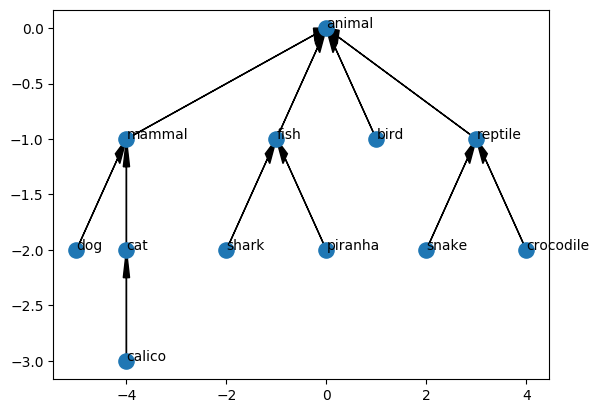

In [38]:
visualize_digraph(example_tree, vertex_dict)
show()

## Write a probabilistic program

Practically a one-liner. All it does is draw samples from our distribution -- there's no posterior inference going on here.

In [ ]:
@gen function graph_generator(reference_graph::DiGraph{String}, beta::Float64)
    g = @trace(graphpriordist(reference_graph, beta), :graph)
    return g
end;

In order to sample from this, we'll need to define a proposal distribution that explores a space of directed graphs.

## A first (naive) proposal distribution

As a first pass, we'll define operations that allow us to explore the space of directed graphs in a mostly unconstrained fashion. 
That is, we won't enforce most graph properties: connectedness, acyclicity, in-degree, etc.
However, we *will* enforce a couple of constraints (mostly for aesthetic reasons): no 1- or 2-cycles.

Our first proposal distribution is sort of naive.
It samples uniformly over the $N(N-1)$ possible directed edges.
If the edge already exists then it flips a coin, deciding whether to remove or reverse that edge.
If the edge doesn't exist but its reverse _does_, then we do similarly for that edge.
If neither the edge nor its reverse exists, then we propose an edge there.

In [ ]:
# First (inefficient) proposal distribution
@gen function naive_digraph_proposal(cur_trace)
    
    G = cur_trace[:graph]
    N = length(G.vertices)
    
    v1 = uniform_discrete(1, N)
    v2 = uniform_discrete(1, N-1) # won't allow self-loops
    if v2 >= v1
        v2 += 1
    end
    
    # If an edge already exists: remove or reverse it
    if length(G.edges[(G.edges[:,1] .== v1) .& (G.edges[:,2] .== v2)]) > 0
        remove = bernoulli(0.5)
        if remove
            remove_edge!(G, v1, v2) # remove
        else
            remove_edge!(G, v1, v2) # reverse
            add_edge!(G, v2, v1)
        end
    # If the edge's reverse exists: remove or reverse that.    
    elseif length(G.edges[(G.edges[:,1] .== v2) .& (G.edges[:,2] .== v1)]) > 0
        remove = bernoulli(0.5)
        if remove
            remove_edge!(G, v2, v1) # remove
        else
            remove_edge!(G, v2, v1) # reverse
            add_edge!(G, v1, v2)
        end
    # If neither the edge nor its reverse exists, add the edge!
    else
        add_edge!(G, v1, v2)
    end
    
    cur_trace[:graph] = G
    
    return cur_trace
end;

We expect this proposal will impose sampling inefficiencies. When the graph is sparse, the proposal tends to add improbable edges, which are in turn rejected by the Metropolis Hastings sampler.

## MCMC sampling: naive proposal distribution

In [ ]:
function graph_sample(model, )
    
    tr, _ = Gen.gener

## A digraph proposal distribution

As mentioned before, the "naive" digraph proposal was inefficient because xyz...

In [ ]:
@gen function digraph_proposal(cur_trace)
   

    
end

In [39]:
d = Dict("a" => Dict("b" => 1), "b" => Dict("b" => 2))

Dict{String,Dict{String,Int64}} with 2 entries:
  "b" => Dict("b"=>2)
  "a" => Dict("b"=>1)

In [41]:
keys(d["a"])

Base.KeySet for a Dict{String,Int64} with 1 entry. Keys:
  "b"

In [43]:
pairs(d)

Dict{String,Dict{String,Int64}} with 2 entries:
  "b" => Dict("b"=>2)
  "a" => Dict("b"=>1)